In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import optimize
from tqdm import tqdm
from multiprocess import Pool

from interaction import potential
from counterterm import local_LO_counterterm
from constants import MU, BETA4
from utility import log_mesh
from free_solutions import phase_shift, phase_shift_interp

plt.style.use('science')
ratio = 4/3
h = 3

Read in RG flow.

In [2]:
rgf = np.loadtxt('rgflow_local_lo_a0_fix_hp_n_14_coord_ir_corrected.txt')

In [3]:
r0 = 4*BETA4
r = np.linspace(3.9*BETA4, 4.1*BETA4, 100)

def wave_function(v_r, energy, r_endpts=np.array([1e-4, 500])):
    sol = solve_ivp(
        lambda r, phi: np.array([phi[1], 2*MU*(v_r(r) - energy) * phi[0]], dtype=object),
        r_endpts, [r_endpts[0], 1], rtol=1e-9, atol=1e-12,
        dense_output=True, method='DOP853'
    )
    return sol.sol


def delta(v_r, energy):
    k = np.sqrt(2*MU*energy)
    rho = k*r
    u, _ = wave_function(v_r, energy)(r)
    return phase_shift_interp(u, rho, 0, k*r0).real

In [4]:
ks = np.hstack(
    (np.logspace(np.log10(0.001/BETA4), np.log10(10/BETA4), 50),
     np.linspace(10.1/BETA4, 100/BETA4, 50))
)
energies = ks**2/(2*MU)

In [10]:
index = 0
R, c0 = rgf[index]
pot = lambda r: potential(r, R) + c0*local_LO_counterterm(r, R)

In [20]:
%%time
deltas = np.array([delta(pot, en) for en in energies])

CPU times: user 10.6 s, sys: 26.5 ms, total: 10.6 s
Wall time: 10.6 s


In [22]:
ks.shape, deltas.shape

((100,), (100,))

In [23]:
deltas_mm = np.loadtxt('phase_shifts_mott_massey_wide_dense.txt')
ks_mm = deltas_mm[:, 0]
deltas_mm = deltas_mm[:, 1]

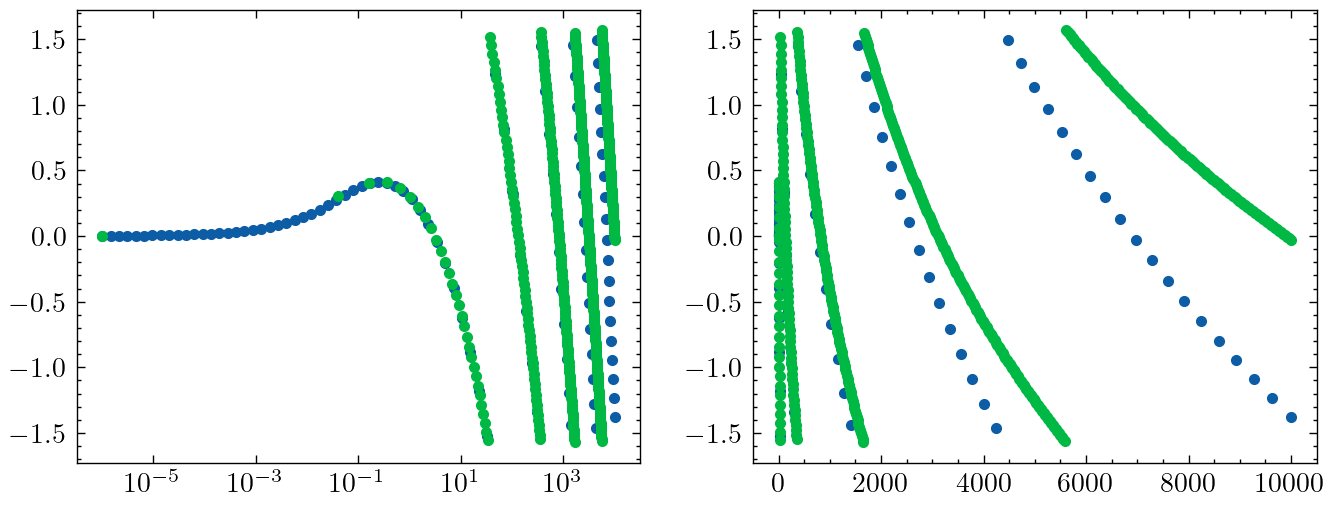

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=200)
fig.patch.set_facecolor('white')

ax[0].scatter((ks*BETA4)**2, deltas, marker='.')
ax[0].scatter((ks_mm*BETA4)**2, deltas_mm, marker='.')
ax[1].scatter((ks*BETA4)**2, deltas, marker='.')
ax[1].scatter((ks_mm*BETA4)**2, deltas_mm, marker='.')

ax[0].set_xscale('log');

In [26]:
deltas = []

for (R, c0) in tqdm(rgf):
    pot = lambda r: potential(r, R) + c0*local_LO_counterterm(r, R)
    with Pool(4) as p:
        ds = p.map(lambda en: delta(pot, en), energies)
    deltas.append(ds)

deltas = np.array(deltas)

100%|███████████████████████████████████████████| 95/95 [06:37<00:00,  4.18s/it]


In [27]:
np.savetxt('phase_shifts_lo_wide_dense_hp_n_14_coord_ir_corrected.txt', np.vstack((ks, deltas)).T)